<a href="https://colab.research.google.com/github/shresth26/S-MART/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data, wb
import datetime
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

## Loading Data

In [2]:
tender = pd.read_csv('tender.csv')
products = pd.read_csv('products.csv')

In [3]:
products.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
0,BBID_20482,1975-10-20,male,MADHYA PRADESH,453441.0,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,NONPROMO,NaN,1000446431,PATANJALI CHOCOS 125g,55.00,Payback
1,BBID_20485,1955-07-21,female,NaN,999999.0,2017-03-09,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,NONPROMO,NaN,1000010431,SOO FRESH ROLLS HOT DOG 4P,30.00,Payback
2,BBID_20498,1981-03-19,female,MAHARASHTRA,400064.0,2015-08-12,2655,BB-INDORE-MALHAR MEGA MALL,13,1064,0000971754,AD 399 FLAT LADIES JEANS FASHION EXC,1000077851005,"DLJ-0010-BSF-2-CJ-FL, 34, BLACK",418.95,Payback
3,BBID_20499,1986-05-10,male,MAHARASHTRA,400099.0,2016-12-18,2615,BB-AMRITSAR-TRILIUM MALL,14,51080,NONPROMO,NaN,1000443231,PATANJALI TOMATO KETCHUP BT 500g,70.00,Payback
4,BBID_204110,1988-02-29,male,MADHYA PRADESH,474001.0,2015-12-31,2655,BB-INDORE-MALHAR MEGA MALL,9,21911,0000974126,NMP 5% OFF CONCEPT DISCOUNT 2655,300481741,MAGGI NDL MERI MASALA PP 70g,34.20,Payback


In [4]:
tender.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,tender_type,transaction_number_by_till,payment_amount_by_tender,PaymentUsed
0,BBID_2044,1984-04-02,male,NaN,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,GVOWN,9208,1000.00,GiftVoucher
1,BBID_2044,1984-04-02,male,NaN,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,CASH,9208,10.46,CASH
2,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,EDCAXIS,90269,677.28,AXIS
3,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,MOBI,90268,1042.00,One MobiKwik Systems
4,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,MOBI,90269,1000.00,One MobiKwik Systems


### Handling Missing values

In [5]:
products['promotion_description'].fillna('no_promo', inplace=True)
products['Gender'].fillna('no_gender', inplace=True)
products['State'].fillna('no_state', inplace=True)
products['PinCode'].fillna(-1, inplace=True)
products['DOB'].fillna("1", inplace=True)

### Converting data into numeric / float

In [6]:
for c in products.columns:
    lbl = LabelEncoder()
    if products[c].dtype == 'object' and c not in ['store_description','customerID','transactionDate']:
        products[c] = lbl.fit_transform(products[c])

In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerID                  11972 non-null  object 
 1   DOB                         11972 non-null  int64  
 2   Gender                      11972 non-null  int64  
 3   State                       11972 non-null  int64  
 4   PinCode                     11972 non-null  float64
 5   transactionDate             11972 non-null  object 
 6   store_code                  11972 non-null  int64  
 7   store_description           11972 non-null  object 
 8   till_no                     11972 non-null  int64  
 9   transaction_number_by_till  11972 non-null  int64  
 10  promo_code                  11972 non-null  int64  
 11  promotion_description       11972 non-null  int64  
 12  product_code                11972 non-null  int64  
 13  product_description         119

In [8]:
products.head(2)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
0,BBID_20482,3108,1,20,453441.0,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,2213,2010,1000446431,4269,55.0,24
1,BBID_20485,594,0,36,999999.0,2017-03-09,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,2213,2010,1000010431,5121,30.0,24


In [9]:
by_store_desc = products.groupby("store_description")
by_store_desc.mean()

,DOB,Gender,State,PinCode,store_code,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
store_description,,,,,,,,,,,,,
BB-AMRITSAR-TRILIUM MALL,3285.408022,0.854772,26.349931,156611.124481,2615.0,8.968188,49042.356846,1882.461964,1458.235131,1.140550e+11,2847.396957,186.455380,8.290456
BB-HUBLI-GOKUL ROAD-AKSHAY CEN,2943.606575,0.914379,19.336705,532821.248916,4796.0,10.396676,48774.490968,1913.524205,1707.052384,9.096180e+10,3025.423410,150.773916,22.810332
BB-INDORE-MALHAR MEGA MALL,3967.847488,0.812794,22.549693,452809.792917,2655.0,7.179256,44456.108782,1964.325623,1779.710878,7.976166e+10,2929.641850,133.752280,18.117456
BB-INDORE-TREASURE ISLAND,4150.093079,0.735084,22.052506,473512.361177,2906.0,8.151949,36687.421639,2027.683373,1784.295147,1.386935e+11,2901.189340,139.138043,20.318218
BB-JAMSHEDPUR-NH-33,3477.519906,0.863232,18.256674,759948.907728,4843.0,10.494145,51589.503981,1837.851522,1605.162061,7.954487e+10,2849.703513,151.799522,23.189227
BB-LUDHIANA-FEROZEPUR-MF,3770.128920,0.860627,25.757840,151556.721254,3692.0,5.205575,50358.003484,1902.461672,1408.918118,1.050238e+11,2826.041812,158.998798,12.562718
BB-MADURAI-KOCHADAI VILLAGE,3326.441648,0.794050,29.400458,572335.250000,4986.0,13.080092,52882.939931,1892.247140,1764.308352,8.145967e+10,2775.545767,141.628381,22.613272


In [10]:
df = products 
df['transactionDate'] = pd.to_datetime(df['transactionDate'])

In [11]:
type(df['transactionDate'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
if(df['customerID'].iloc[0].split('_')[0] != 'BBID'):
    df['customerID'] = df['customerID'].apply(lambda bbid: "BBID_"+bbid)

In [13]:
stores = list(set(df['store_code']))

cluster_labels = []
cluster_store = []
cluster_data = []
cluster_customers = []
cluster_score = []

for x in stores:
    cld = df[df['store_code'] == x]
    cluster_customers.append(cld['customerID'])
    cld.drop(['store_code','customerID','transactionDate','store_description'], axis=1, inplace=True)
    
    rbs = RobustScaler()
    cld2 = rbs.fit_transform(cld)
    
    km1 = KMeans(n_clusters=6)
    km2 = km1.fit(cld2)
    label = km2.predict(cld2)
    
    s_score = silhouette_score(cld2, label)
    cluster_score.append(s_score)
    
    cluster_labels.append(label)
    cluster_store.append(np.repeat(x, cld.shape[0]))
    cluster_data.append(cld2)

In [14]:
## merge list into ndarray
cluster_data = np.concatenate(cluster_data)
## convert nested lists as 1d array
cluster_customers = np.concatenate(cluster_customers)
cluster_store = np.concatenate(cluster_store)
cluster_labels = np.concatenate(cluster_labels)

### Creating submission files

In [15]:
sub1 = pd.DataFrame({'customerID':cluster_customers, 'store_code':cluster_store, 'cluster':cluster_labels})

In [16]:
np.savetxt('subOne_18.txt', cluster_data)
sub1.to_csv('subtwo_18.csv', index=False)

In [17]:
cluster_customers_number = []
for x in cluster_customers:
    cluster_customers_number.append(x.split('_')[1])
cluster_customers_number = np.array(cluster_customers_number)

In [18]:
df['customerID'] = df['customerID'].apply(lambda num: num.split('_')[1])

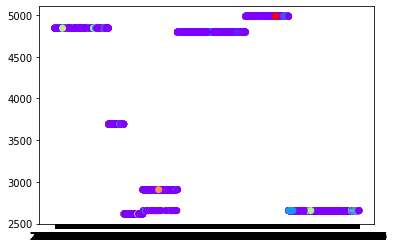

In [19]:
plt.scatter(cluster_customers_number,cluster_store,c=cluster_labels,cmap='rainbow')

In [20]:
def converter(store_desc):
    if store_desc=='BB-AMRITSAR-TRILIUM MALL':
        return 1
    elif store_desc=='BB-HUBLI-GOKUL ROAD-AKSHAY CEN':
        return 2
    elif store_desc=='BB-INDORE-MALHAR MEGA MALL':
        return 3
    elif store_desc=='BB-INDORE-TREASURE ISLAND':
        return 4
    elif store_desc=='BB-JAMSHEDPUR-NH-33':
        return 5
    elif store_desc=='BB-LUDHIANA-FEROZEPUR-MF':
        return 6
    elif store_desc=='BB-MADURAI-KOCHADAI VILLAGE':
        return 7
    else:
        return 8

df['store_description_no'] = df['store_description'].apply(converter) 